# Imports

In [3]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import sklearn.model_selection
import sklearn.preprocessing as preproc
from sklearn.feature_extraction import text
import pickle
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Inspecting Dataset

In [4]:
# load the dataset
df = pd.read_csv('/content/Combined Data.csv', index_col=0)
df.shape

(53043, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [6]:
df.describe()

,statement,status
count,52681,53043
unique,51073,7
top,what do you mean?,Normal
freq,22,16351


In [7]:
# drop the rows containing null values
df = df.dropna()
df.shape

(52681, 2)

In [8]:
# output the first tow rows of the dataset
df.head(2)

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety


# Data Cleaning

- __Deduplication__ Removing the dublicate rows, which share the same UserId, ProfileName, Time, and Text

In [9]:
df.duplicated(subset=['statement']).value_counts()

,count
False,51073
True,1608


In [10]:
df.drop_duplicates(subset=['statement'],inplace=True)

In [11]:
df.duplicated(subset=['statement']).value_counts()

,count
False,51073


In [12]:
df.shape

(51073, 2)

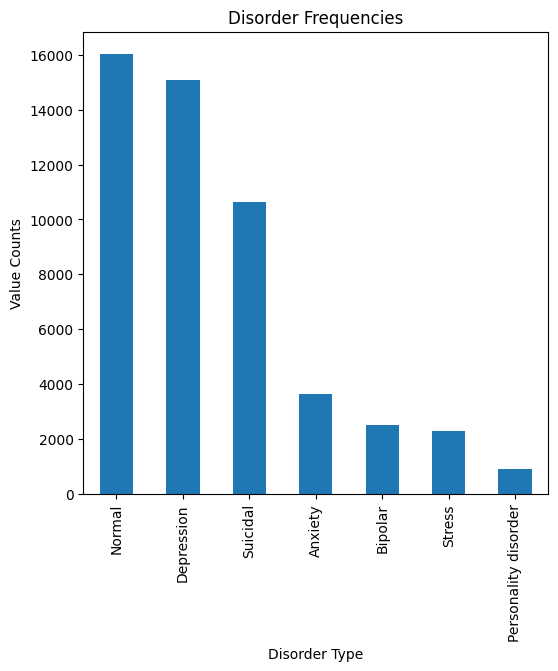

In [13]:
# create a histogram showing the review distribution over scores from 1 to 5
# value counts is pandas built in function that counts the number of occurences of different values in a series (numerical column)
# plot is a pandas built in function to plot the values of a series (it uses matplotlib by default)
ax = df['status'].value_counts().plot(kind='bar', figsize=(6,6))

# get figure returns a matplotlib object (figure)
fig = ax.get_figure()

# built in matplotlib functions
ax.set_title("Disorder Frequencies")
ax.set_xlabel('Disorder Type')
ax.set_ylabel('Value Counts');

In [14]:
# Create a label column in the dataframe and assing all its values to 0
df['Label'] = 0
df.head(1)

,statement,status,Label
0,oh my gosh,Anxiety,0


In [15]:
def cluster_status(status):
    if status in ['Anxiety','Bipolar','Stress','Personality disorder']:
        return 3
    elif status == 'Normal':
        return 0
    elif status == 'Depression':
        return 1
    elif status == 'Suicidal':
        return 2

In [16]:
df['Label']=df['status'].apply(cluster_status)

In [17]:
# df.loc[df['status']=='Anxiety'].head()  # note that we checked differnt status to be sure
df.loc[df['status']=='Normal'].head()

,statement,status,Label
733,"Gr gr dreaming of ex crush to be my game, God",Normal,0
734,wkwkwk what a joke,Normal,0
735,Leaves are also standby in front of the PC ......,Normal,0
736,Thank God even though it's just a ride through,Normal,0
737,wedding teaser concept using the song day6 - o...,Normal,0


# Text Preprocessing

In [18]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [19]:
# function to replace the contracted words with their longer counterparts
def decontract_words(text):
    text = text.split()
    new_text = []
    for word in text:
        if word in contractions:
            new_text.append(contractions[word])
        else:
            new_text.append(word)
    return " ".join(new_text)

In [20]:
# function to format words and remove unwanted characters using regex
def format_text_regex(text):
    # ^https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%.\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b(?:[-a-zA-Z0-9()@:%\+.~#?&\/=]*)$
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE) #clean all URLs
    text = re.sub(r'\<a href', ' ', text) #clean html style URL
    text = re.sub(r'&amp;', '', text) #remove &amp; chars
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text) #remove special characters
    text = re.sub(r'<br />', ' ', text) #remove html style <br>
    text = re.sub(r'\'', ' ', text)
    return text

In [21]:
# function to remove stop words usng the nltk
nltk.download('stopwords')
def remove_stopwords(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    return " ".join(text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
# function that groups logic from other preprocessing functions to clean text
def clean_text(text):

    # Convert words to lower case
    text = text.lower()

    # Use other preprocessing functions
    text = decontract_words(text)
    text = format_text_regex(text)
    text = remove_stopwords(text)

    # Tokenize each word
    text =  nltk.WordPunctTokenizer().tokenize(text)

    return text

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51073 entries, 0 to 52840
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  51073 non-null  object
 1   status     51073 non-null  object
 2   Label      51073 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


In [24]:
# Use the map to apply the clean_text on the df.statement column and store the result in a new column called text_cleaned
df['Text_Cleaned'] = list(map(clean_text, df.statement))
df.head(3)

,statement,status,Label,Text_Cleaned
0,oh my gosh,Anxiety,3,"[oh, gosh]"
1,"trouble sleeping, confused mind, restless hear...",Anxiety,3,"[trouble, sleeping, confused, mind, restless, ..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,3,"[wrong, back, dear, forward, doubt, stay, rest..."


In [25]:
# function to lemmatize words in text cleaned and create a new column lemmatized text and store them there
def lemmatized_words(text):
    lemm = nltk.stem.WordNetLemmatizer()
    df['lemmatized_text'] = list(map(lambda word:
                                     list(map(lemm.lemmatize, word)),
                                     df.Text_Cleaned))


lemmatized_words(df.Text_Cleaned)
df.head(3)

,statement,status,Label,Text_Cleaned,lemmatized_text
0,oh my gosh,Anxiety,3,"[oh, gosh]","[oh, gosh]"
1,"trouble sleeping, confused mind, restless hear...",Anxiety,3,"[trouble, sleeping, confused, mind, restless, ...","[trouble, sleeping, confused, mind, restless, ..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,3,"[wrong, back, dear, forward, doubt, stay, rest...","[wrong, back, dear, forward, doubt, stay, rest..."


In [26]:
# optional line to adjust table width
pd.set_option('max_colwidth', 500)

# sample the data after preprocessing
df[[ 'statement', 'Text_Cleaned', 'lemmatized_text','status']].head(600)

,statement,Text_Cleaned,lemmatized_text,status
0,oh my gosh,"[oh, gosh]","[oh, gosh]",Anxiety
1,"trouble sleeping, confused mind, restless heart. All out of tune","[trouble, sleeping, confused, mind, restless, heart, tune]","[trouble, sleeping, confused, mind, restless, heart, tune]",Anxiety
2,"All wrong, back off dear, forward doubt. Stay in a restless and restless place","[wrong, back, dear, forward, doubt, stay, restless, restless, place]","[wrong, back, dear, forward, doubt, stay, restless, restless, place]",Anxiety
3,I've shifted my focus to something else but I'm still worried,"[shifted, focus, something, else, still, worried]","[shifted, focus, something, else, still, worried]",Anxiety
4,"I'm restless and restless, it's been a month now, boy. What do you mean?","[restless, restless, month, boy, mean]","[restless, restless, month, boy, mean]",Anxiety
...,...,...,...,...
612,"Yes, the point is that I feel tired, sad, annoyed, restless. It's like the feeling is mixed in my heart and mind, in my brain I'm traveling various things from problems to happiness that I've felt until this moment.","[yes, point, feel, tired, sad, annoyed, restless, like, feeling, mixed, heart, mind, brain, traveling, various, things, problems, happiness, felt, moment]","[yes, point, feel, tired, sad, annoyed, restless, like, feeling, mixed, heart, mind, brain, traveling, various, thing, problem, happiness, felt, moment]",Anxiety
613,Hmm why are you so nervous,"[hmm, nervous]","[hmm, nervous]",Anxiety
614,restless and worrying too much,"[restless, worrying, much]","[restless, worrying, much]",Anxiety
615,"When the effects of the depressant have started to wear off and the depression phase has started, it's really tiring","[effects, depressant, started, wear, depression, phase, started, really, tiring]","[effect, depressant, started, wear, depression, phase, started, really, tiring]",Anxiety


### Vizualizing the Length Distribution for our Lemmatized Text

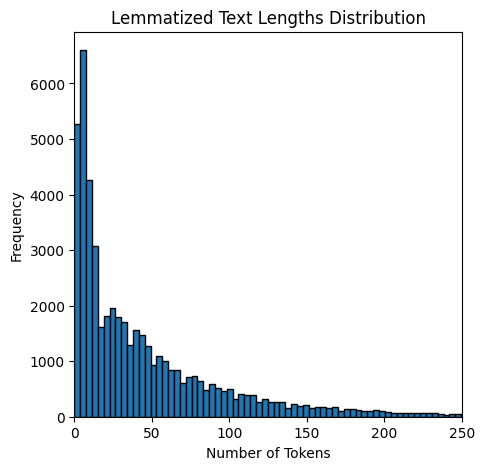

In [27]:
lengths = df['lemmatized_text'].apply(len)

fig,ax=plt.subplots(figsize=(5,5))
ax.hist(lengths,bins=1000,edgecolor='black')
ax.set_title('Lemmatized Text Lengths Distribution')
ax.set_xlabel('Number of Tokens')
ax.set_ylabel('Frequency')
ax.set_xlim(0,250)
plt.show()


In [28]:
(df['lemmatized_text'].apply(len) > 100).value_counts()

,count
lemmatized_text,
False,43350
True,7723


In [29]:
(df['lemmatized_text'].apply(len) > 125).value_counts()

,count
lemmatized_text,
False,45758
True,5315


In [30]:
(df['lemmatized_text'].apply(len) > 150).value_counts()

,count
lemmatized_text,
False,47233
True,3840


Based on the above figure, we found it logical to set the sequence length to 125 as a middle way between short and long sequences.

In [31]:
sequence_length=125

## W2Vector embedding

In [32]:
## getting the data ready
data=df['lemmatized_text'].to_list()

In [33]:
data[:10]

[['oh', 'gosh'],
 ['trouble', 'sleeping', 'confused', 'mind', 'restless', 'heart', 'tune'],
 ['wrong',
  'back',
  'dear',
  'forward',
  'doubt',
  'stay',
  'restless',
  'restless',
  'place'],
 ['shifted', 'focus', 'something', 'else', 'still', 'worried'],
 ['restless', 'restless', 'month', 'boy', 'mean'],
 ['every', 'break', 'must', 'nervous', 'like', 'something', 'wrong', 'heck'],
 ['feel', 'scared', 'anxious', 'may', 'family', 'u', 'protected'],
 ['ever', 'felt', 'nervous', 'know'],
 ['slept', 'well', '2', 'day', 'like', 'restless', 'huh'],
 ['really', 'worried', 'want', 'cry']]

In [34]:
import gensim
from gensim.models import Word2Vec
import warnings

warnings.filterwarnings(action='ignore')

In [35]:
embedding_size=300
# Create CBOW model
model_cbow = gensim.models.Word2Vec(data, min_count=1,
                                vector_size=embedding_size, window=10)

In [36]:
model_cbow.wv['gosh']

array([ 0.00878975, -0.01023117, -0.05999797,  0.12608849,  0.16910453,
       -0.03233052,  0.02926807,  0.07676207,  0.0739871 , -0.0837993 ,
        0.0180738 , -0.11628714,  0.06831345, -0.0086078 , -0.08064554,
        0.02345169, -0.01102237, -0.04727242,  0.0596103 ,  0.1216834 ,
       -0.12616757,  0.07789709,  0.01629597,  0.02264495,  0.08901156,
        0.08475657,  0.02350325, -0.0393285 , -0.03513982, -0.0591691 ,
       -0.21624455,  0.08256544,  0.01781911, -0.15591872,  0.06545634,
        0.2988336 ,  0.02124329, -0.17501028, -0.16622123,  0.01729871,
       -0.17566164,  0.06853662,  0.27462968, -0.06723837, -0.12884578,
       -0.01583683, -0.173758  ,  0.16634092, -0.01682585,  0.11784674,
        0.12350617,  0.03294566, -0.08796453, -0.06996462, -0.02605063,
       -0.0331637 ,  0.04666992, -0.03582903,  0.04679418, -0.15442662,
       -0.17527209, -0.0732862 , -0.1267984 ,  0.14700222, -0.02914515,
       -0.02622194,  0.08477233, -0.11976615, -0.01996195,  0.16

### Splitting the data

In [37]:
df.head()

,statement,status,Label,Text_Cleaned,lemmatized_text
0,oh my gosh,Anxiety,3,"[oh, gosh]","[oh, gosh]"
1,"trouble sleeping, confused mind, restless heart. All out of tune",Anxiety,3,"[trouble, sleeping, confused, mind, restless, heart, tune]","[trouble, sleeping, confused, mind, restless, heart, tune]"
2,"All wrong, back off dear, forward doubt. Stay in a restless and restless place",Anxiety,3,"[wrong, back, dear, forward, doubt, stay, restless, restless, place]","[wrong, back, dear, forward, doubt, stay, restless, restless, place]"
3,I've shifted my focus to something else but I'm still worried,Anxiety,3,"[shifted, focus, something, else, still, worried]","[shifted, focus, something, else, still, worried]"
4,"I'm restless and restless, it's been a month now, boy. What do you mean?",Anxiety,3,"[restless, restless, month, boy, mean]","[restless, restless, month, boy, mean]"


In [38]:
X=df['lemmatized_text']
y=df['Label']

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.15,random_state=42)

### Converting embeddings to tensors

In [41]:

import torch
import torch.nn as nn

In [ ]:
def convert_sequences_to_tensor(sequences, num_tokens_in_sequence, embedding_size):
    '''
    We want a torch.FloatTensor() of size (num_sequences, num_tokens_in_sequence, embedding_size)
    '''
    num_sequences = len(sequences)
    print((num_sequences, num_tokens_in_sequence, embedding_size))

    data_tensor = torch.zeros((num_sequences, num_tokens_in_sequence, embedding_size))

    for index, review in enumerate(list(sequences)):
        # Create a word embedding for each word in the review (where a review is a sequence)
        truncated_clean_review = review[:num_tokens_in_sequence]  # truncate to sequence length limit

        if len(truncated_clean_review) == 0: # accounting for the case where some words might not be recognized by the word2vector model
            continue

        list_of_word_embeddings = [
            model_cbow.wv[word] if word in model_cbow.wv else [0.0] * embedding_size for word in truncated_clean_review
        ]

        # convert the review to a tensor
        sequence_tensor = torch.FloatTensor(list_of_word_embeddings)

        # add the review to our tensor of data
        review_length = sequence_tensor.shape[0]  # (review_length, embedding_size)
        data_tensor[index, :review_length, :] = sequence_tensor

    return data_tensor


In [ ]:
train_data_X = convert_sequences_to_tensor(X_train.to_numpy(), sequence_length, embedding_size)
train_data_y = torch.FloatTensor([int(d) for d in y_train.to_numpy()])

test_data_X = convert_sequences_to_tensor(X_test.to_numpy(), sequence_length, embedding_size)
test_data_y = torch.FloatTensor([int(d) for d in y_test.to_numpy()])

(43412, 125, 300)
(7661, 125, 300)


#### Double checking for consistency

In [ ]:
len(train_data_X),len(train_data_y)

(43412, 43412)

In [ ]:
len(test_data_X),len(test_data_y)

(7661, 7661)

### Loading the data

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
train_data = TensorDataset(train_data_X, train_data_y)
test_data = TensorDataset(test_data_X, test_data_y)

In [ ]:
batch_size=25
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# LSTM Model

### Training the model

#### Monitoring our Data

In [ ]:
train_data[0]

(tensor([[ 0.0232, -0.2021,  0.2335,  ..., -0.0040,  0.1520,  0.0167],
         [-1.0337, -0.6775, -1.2836,  ..., -0.8939,  0.6153, -0.2091],
         [ 0.5585, -0.8154,  0.3793,  ...,  0.0377,  0.1625, -0.2452],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]),
 tensor(1.))

#### implementing our class

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

In [46]:
device ='cuda' if torch.cuda.is_available() else 'cpu'

The following code adopt a similar structure to the rnn and gru implementations.

In [ ]:
class LSTM(nn.Module):
    def __init__(self,input_size, hidden_size,num_layers, num_classes):
        super(LSTM,self).__init__()
        self.num_layers=num_layers
        self.hidden_size=hidden_size
        self.lstm= nn.LSTM(input_size,hidden_size,num_layers,batch_first=True) # batch must be in first dimension
        # if batch first was set to true, input shape: batch size,sequence number, features size
        self.fc=nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0=torch.zeros(self.num_layers, x.size(0),self.hidden_size).to(device)
        c0=torch.zeros(self.num_layers, x.size(0),self.hidden_size).to(device)
        out, _= self.lstm(x,(h0,c0)) # we do not need the second returned output (h_n, c_n) - final states at each layer
        out=out[:,-1,:]
        out = self.fc(out)
        return out

### Model 1

In [ ]:
hidden_size=256
num_layers=3

In [ ]:
lstm_classifier_1=LSTM(input_size=embedding_size,hidden_size=hidden_size,num_layers=num_layers,num_classes=4)

In [ ]:
learning_rate=0.001 # setting the lea
# for the optimizer, we may use either the adam or the sgd optimizers
optimizer = Adam(lstm_classifier_1.parameters(), lr=learning_rate)
# we are dealing with multi class classification problem, thus will use cross entropy loss
loss_criterion=nn.CrossEntropyLoss()

In [ ]:
# Let's see how many Parameters our Model has!
num_model_params = 0
for param in lstm_classifier_1.parameters():
    num_model_params += param.flatten().shape[0]

num_model_params

1625092

#### Training phase

In [ ]:
lstm_classifier_1.to(device)

LSTM(
  (lstm): LSTM(300, 256, num_layers=3, batch_first=True)
  (fc): Linear(in_features=256, out_features=4, bias=True)
)

In [ ]:
epochs=10

# Initialize training and test accuracy
train_acc = 0
test_acc = 0

# Loop through each epoch
for epoch in range(epochs):
    # Update progress bar description with current accuracy

    # Set model to training mode
    lstm_classifier_1.train()
    running_loss=0.0
    # Iterate through training data loader
    for text,labels in train_loader:
        # bs = labels.shape[0]

        text=text.to(device)
        labels = labels.long().to(device)

        # print('text tensor:',text)
        # print('text shape:',text.shape)
        # print('label tensor:',label)

        # Initialize hidden and memory states
        # hidden = torch.zeros(num_layers, bs, hidden_size, device=device)
        # memory = torch.zeros(num_layers, bs, hidden_size, device=device)

        # Forward pass through the model
        outputs = lstm_classifier_1(text)

        # Calculate the loss
        loss = loss_criterion(outputs, labels)
        running_loss+=loss.item()

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    average_loss=running_loss/ len(train_loader)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {average_loss}')


Epoch [1/10], Loss: 0.869624037936836
Epoch [2/10], Loss: 0.6256229815962813
Epoch [3/10], Loss: 0.5680555929448595
Epoch [4/10], Loss: 0.521328924833939
Epoch [5/10], Loss: 0.47743216730015126
Epoch [6/10], Loss: 0.43954661914893245
Epoch [7/10], Loss: 0.39236406348409775
Epoch [8/10], Loss: 0.3482256204353095
Epoch [9/10], Loss: 0.3052753558662271
Epoch [10/10], Loss: 0.26389656927507366


Let us try to increase the number of epochs to 15 to allow our model to train more

In [ ]:
lstm_classifier_2=LSTM(input_size=embedding_size,hidden_size=hidden_size,num_layers=num_layers,num_classes=4)

In [ ]:
learning_rate=0.001
optimizer = Adam(lstm_classifier_2.parameters(), lr=learning_rate)
loss_criterion=nn.CrossEntropyLoss()

In [ ]:
lstm_classifier_2.to(device)

LSTM(
  (lstm): LSTM(300, 256, num_layers=3, batch_first=True)
  (fc): Linear(in_features=256, out_features=4, bias=True)
)

In [ ]:
epochs=15

# Initialize training and test accuracy
train_acc = 0
test_acc = 0

# Loop through each epoch
for epoch in range(epochs):
    # Update progress bar description with current accuracy

    # Set model to training mode
    lstm_classifier_2.train()
    running_loss=0.0
    # Iterate through training data loader
    for text,labels in train_loader:
        # bs = labels.shape[0]

        text=text.to(device)
        labels = labels.long().to(device)

        # print('text tensor:',text)
        # print('text shape:',text.shape)
        # print('label tensor:',label)

        # Initialize hidden and memory states
        # hidden = torch.zeros(num_layers, bs, hidden_size, device=device)
        # memory = torch.zeros(num_layers, bs, hidden_size, device=device)

        # Forward pass through the model
        outputs = lstm_classifier_2(text)

        # Calculate the loss
        loss = loss_criterion(outputs, labels)
        running_loss+=loss.item()

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    average_loss=running_loss/ len(train_loader)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {average_loss}')

Epoch [1/15], Loss: 0.9710846660668369
Epoch [2/15], Loss: 0.6601907367258835
Epoch [3/15], Loss: 0.5744890228179795
Epoch [4/15], Loss: 0.5212915767848526
Epoch [5/15], Loss: 0.577023297522558
Epoch [6/15], Loss: 0.5067762620125136
Epoch [7/15], Loss: 0.4611450318090519
Epoch [8/15], Loss: 0.4214520062790153
Epoch [9/15], Loss: 0.3780832311366918
Epoch [10/15], Loss: 0.33816815543411516
Epoch [11/15], Loss: 0.29416516745783644
Epoch [12/15], Loss: 0.2549882162583238
Epoch [13/15], Loss: 0.21537091436532632
Epoch [14/15], Loss: 0.18418409042092546
Epoch [15/15], Loss: 0.1616770026102988


Let us now evaluate the performance of our model

#### Creating Our evaluation method

In [43]:
from torch.utils.tensorboard import SummaryWriter

In [44]:
# i used insights from pattrick lobber github cnn code and tensorboard video to develop the following method, refrence provided in report
import torch.nn.functional as F
def evaluate_model(model, test_dataloader, loss_criterion, device, writer=None):
    model.eval()
    total_loss=0.0
    total_samples=0
    correct_classifications=0
    # for the pr curve
    all_probs=[]
    all_labels=[]
    size=len(test_dataloader) # dataset size
    with torch.no_grad():
        for text,labels in test_dataloader:
            text=text.to(device)
            labels=labels.long().to(device)

            outputs=model(text)
            loss=loss_criterion(outputs,labels)
            total_loss+=loss.item()

            probs = F.softmax(outputs, dim=1)
            predicted_classes = torch.argmax(outputs, dim=1)
            correct_classifications += (predicted_classes == labels).sum().item()
            total_samples += labels.size(0)

            all_probs.extend(probs.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    avg_class_loss=total_loss/size
    classification_accuracy=100.0*(correct_classifications/total_samples)

    print(f"Average Classification Loss: {avg_class_loss}")
    print(f"Classification Accuracy: {classification_accuracy}%")


    if writer is not None: # i want to use a writer for every model so that i may see the results and compare them
        writer.add_scalar('Loss/Classification', avg_class_loss, 0)
        writer.add_scalar('Accuracy/Classification', classification_accuracy, 0)
        # log per class the pr curves
        for class_index in range(len(all_probs[0])):
            writer.add_pr_curve(
                f'PR_Curve/Class_{class_index}',
                torch.tensor([label == class_index for label in all_labels], dtype=torch.uint8),
                torch.tensor([prob[class_index] for prob in all_probs]),
                global_step=0
            )



#### evaluating our first model

In [ ]:
evaluate_model(lstm_classifier_2, test_loader, loss_criterion, device, writer=SummaryWriter('runs/model_1'))

Average Classification Loss: 0.8348020230714195
Classification Accuracy: 76.34773528260018%


### Finetuning our Model

first, we will start by changing the learning rate to half the past value. Moreover, I will try setting the hidden size to 512 and train the model for 15 epochs.

In [ ]:
hidden_size=512

In [ ]:
lstm_classifier_3=LSTM(input_size=embedding_size,hidden_size=hidden_size,num_layers=num_layers,num_classes=4)

In [ ]:
learning_rate=learning_rate/2
optimizer = Adam(lstm_classifier_3.parameters(), lr=learning_rate)
loss_criterion=nn.CrossEntropyLoss()

In [ ]:
lstm_classifier_3.to(device)

LSTM(
  (lstm): LSTM(300, 512, num_layers=3, batch_first=True)
  (fc): Linear(in_features=512, out_features=4, bias=True)
)

In [ ]:
epochs=15

# Initialize training and test accuracy
train_acc = 0
test_acc = 0

# Loop through each epoch
for epoch in range(epochs):
    # Update progress bar description with current accuracy

    # Set model to training mode
    lstm_classifier_3.train()
    running_loss=0.0
    # Iterate through training data loader
    for text,labels in train_loader:
        # bs = labels.shape[0]

        text=text.to(device)
        labels = labels.long().to(device)

        # print('text tensor:',text)
        # print('text shape:',text.shape)
        # print('label tensor:',label)

        # Initialize hidden and memory states
        # hidden = torch.zeros(num_layers, bs, hidden_size, device=device)
        # memory = torch.zeros(num_layers, bs, hidden_size, device=device)

        # Forward pass through the model
        outputs = lstm_classifier_3(text)

        # Calculate the loss
        loss = loss_criterion(outputs, labels)
        running_loss+=loss.item()

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    average_loss=running_loss/ len(train_loader)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {average_loss}')

Epoch [1/15], Loss: 1.1543518596499833
Epoch [2/15], Loss: 0.8748918678407773
Epoch [3/15], Loss: 0.6540343460847265
Epoch [4/15], Loss: 0.5758533428370026
Epoch [5/15], Loss: 0.5250701154520543
Epoch [6/15], Loss: 0.47981499908004055
Epoch [7/15], Loss: 0.42529954976162554
Epoch [8/15], Loss: 0.37064207368409696
Epoch [9/15], Loss: 0.3145915299726926
Epoch [10/15], Loss: 0.2588949281417764
Epoch [11/15], Loss: 0.21059165045696218
Epoch [12/15], Loss: 0.16848075825551598
Epoch [13/15], Loss: 0.1360465545203509
Epoch [14/15], Loss: 0.11407547248001963
Epoch [15/15], Loss: 0.09319619160286532


#### evaluating our finetuned model performance

In [ ]:
evaluate_model(lstm_classifier_3, test_loader, loss_criterion, device, writer=SummaryWriter('runs/model_2'))

Average Classification Loss: 1.0187871278254528
Classification Accuracy: 76.0997258843493%


Athough the model loss in the training phase decreased in comparison with the our first model, a similar (slightly less) accuracy was obtained on the test data. Thus, this means that our model is overfitting, thats why we will keep our hidden layers number as is and introduce dropouts. Note that from now on, we will adopt our new learning rate.

### Adding dropouts

We will add dropouts so that our model becomes prone to overfitting

In [ ]:
class LSTM_V1(nn.Module):
    def __init__(self,input_size, hidden_size,num_layers, num_classes):
        super(LSTM_V1,self).__init__()
        self.num_layers=num_layers
        self.hidden_size=hidden_size
        self.lstm= nn.LSTM(input_size,hidden_size,num_layers,batch_first=True,dropout=0.3)
        self.fc=nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0=torch.zeros(self.num_layers, x.size(0),self.hidden_size).to(device)
        c0=torch.zeros(self.num_layers, x.size(0),self.hidden_size).to(device)
        out, _= self.lstm(x,(h0,c0)) # we do not need the second returned output (h_n)
        out=out[:,-1,:]
        out = self.fc(out)
        return out

In [ ]:
lstm_classifier_4=LSTM_V1(input_size=embedding_size,hidden_size=hidden_size,num_layers=num_layers,num_classes=4)

In [ ]:
optimizer = Adam(lstm_classifier_4.parameters(), lr=learning_rate)
loss_criterion=nn.CrossEntropyLoss()

In [ ]:
lstm_classifier_4.to(device)

LSTM_V1(
  (lstm): LSTM(300, 512, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=512, out_features=4, bias=True)
)

In [ ]:
epochs=15

# Initialize training and test accuracy
train_acc = 0
test_acc = 0

# Loop through each epoch
for epoch in range(epochs):
    # Update progress bar description with current accuracy

    # Set model to training mode
    lstm_classifier_4.train()
    running_loss=0.0
    # Iterate through training data loader
    for text,labels in train_loader:
        # bs = labels.shape[0]

        text=text.to(device)
        labels = labels.long().to(device)

        # print('text tensor:',text)
        # print('text shape:',text.shape)
        # print('label tensor:',label)

        # Initialize hidden and memory states
        # hidden = torch.zeros(num_layers, bs, hidden_size, device=device)
        # memory = torch.zeros(num_layers, bs, hidden_size, device=device)

        # Forward pass through the model
        outputs = lstm_classifier_4(text)

        # Calculate the loss
        loss = loss_criterion(outputs, labels)
        running_loss+=loss.item()

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    average_loss=running_loss/ len(train_loader)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {average_loss}')

Epoch [1/15], Loss: 0.9597894063645145
Epoch [2/15], Loss: 0.7186096153282612
Epoch [3/15], Loss: 0.6458067005659975
Epoch [4/15], Loss: 0.6084104004987849
Epoch [5/15], Loss: 0.5695538812230632
Epoch [6/15], Loss: 0.5348890919279078
Epoch [7/15], Loss: 0.5068962416757985
Epoch [8/15], Loss: 0.4740452340444272
Epoch [9/15], Loss: 0.4441381752722622
Epoch [10/15], Loss: 0.41191451802686774
Epoch [11/15], Loss: 0.37555808124438605
Epoch [12/15], Loss: 0.3385550942471402
Epoch [13/15], Loss: 0.2978308242378423
Epoch [14/15], Loss: 0.25740316094670856
Epoch [15/15], Loss: 0.22228090015867866


#### evaluating our finetuned model performance

In [ ]:
evaluate_model(lstm_classifier_4, test_loader, loss_criterion, device, writer=SummaryWriter('runs/model_3'))

Average Classification Loss: 0.7751262835939855
Classification Accuracy: 77.0395509724579%


There is an increase in the accuracy in comparison with the previous models with respect to the test data. Better results will be achieved in the model is trained for 5 more epochs

### Trying the bidirectional LSTM

In [54]:
class LSTM_V2(nn.Module):
    def __init__(self,input_size, hidden_size,num_layers, num_classes):
        super(LSTM_V2,self).__init__()
        self.num_layers=num_layers
        self.hidden_size=hidden_size
        self.lstm= nn.LSTM(input_size,hidden_size,num_layers,batch_first=True,dropout=0.3,bidirectional=True) # batch must be in first dimension
        # if batch first was set to true, input shape: batch size,sequence number, features size
        self.fc=nn.Linear(hidden_size*2, num_classes)

    def forward(self, x):
        num_directions = 2  # we need to accomodate the hidden and cell states to both directions
        h0=torch.zeros(self.num_layers*num_directions, x.size(0),self.hidden_size).to(device)
        c0=torch.zeros(self.num_layers*num_directions, x.size(0),self.hidden_size).to(device)
        out, _= self.lstm(x,(h0,c0)) # we do not need the second returned output (h_n)
        out=out[:,-1,:]
        out = self.fc(out)
        return out

we will be now processing in two directions, one from the start to the end and the other vice versa. For each directional step we need to use one hidden size. Thats why we will need to double the hidden size for the last layer to concatenate the forward and backward outputs. Thus, it will be reasonable to drop the hidden size to 256 ( if it remains 512, we will recieve an input of size 1024 at the last layer, resulting in increasing overfitting risk, extra memory usage, and slower training)

In [ ]:
hidden_size=256
lstm_classifier_5=LSTM_V2(input_size=embedding_size,hidden_size=hidden_size,num_layers=num_layers,num_classes=4)

In [ ]:
optimizer = Adam(lstm_classifier_5.parameters(), lr=learning_rate)
loss_criterion=nn.CrossEntropyLoss()

In [ ]:
lstm_classifier_5.to(device)

LSTM_V2(
  (lstm): LSTM(300, 256, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=512, out_features=4, bias=True)
)

In [ ]:
epochs=15

# Initialize training and test accuracy
train_acc = 0
test_acc = 0

# Loop through each epoch
for epoch in range(epochs):
    # Update progress bar description with current accuracy

    # Set model to training mode
    lstm_classifier_5.train()
    running_loss=0.0
    # Iterate through training data loader
    for text,labels in train_loader:
        # bs = labels.shape[0]

        text=text.to(device)
        labels = labels.long().to(device)

        # print('text tensor:',text)
        # print('text shape:',text.shape)
        # print('label tensor:',label)

        # Initialize hidden and memory states
        # hidden = torch.zeros(num_layers, bs, hidden_size, device=device)
        # memory = torch.zeros(num_layers, bs, hidden_size, device=device)

        # Forward pass through the model
        outputs = lstm_classifier_5(text)

        # Calculate the loss
        loss = loss_criterion(outputs, labels)
        running_loss+=loss.item()

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    average_loss=running_loss/ len(train_loader)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {average_loss}')

Epoch [1/15], Loss: 0.8691808864791708
Epoch [2/15], Loss: 0.6515010031874179
Epoch [3/15], Loss: 0.5873475208681208
Epoch [4/15], Loss: 0.53680898607738
Epoch [5/15], Loss: 0.4944985058452456
Epoch [6/15], Loss: 0.4554186855830471
Epoch [7/15], Loss: 0.4168819786404904
Epoch [8/15], Loss: 0.3780861123238203
Epoch [9/15], Loss: 0.334465088336699
Epoch [10/15], Loss: 0.29048477168364917
Epoch [11/15], Loss: 0.2520993145297469
Epoch [12/15], Loss: 0.2199809644521398
Epoch [13/15], Loss: 0.18602034305938117
Epoch [14/15], Loss: 0.16189876927312724
Epoch [15/15], Loss: 0.13929175232871124


#### evaluating our finetuned model performance

In [ ]:
evaluate_model(lstm_classifier_5, test_loader, loss_criterion, device, writer=SummaryWriter('runs/model_4'))

Average Classification Loss: 0.8172653004745513
Classification Accuracy: 77.97937606056651%


There is a slight increase in the classification accuaracy, but this is not enough. This being said, I will try now to increase the number of training epochs to 20, apply L2 regularization to our adam optimizer, and set the learning rate to half its past value.

#### Bidirectional LSTM V2

In [ ]:
hidden_size=256
lstm_classifier_6=LSTM_V2(input_size=embedding_size,hidden_size=hidden_size,num_layers=num_layers,num_classes=4)

In [ ]:
learning_rate=learning_rate/2
optimizer = Adam(lstm_classifier_6.parameters(), lr=learning_rate,weight_decay=0.00001)
loss_criterion=nn.CrossEntropyLoss()

In [ ]:
lstm_classifier_6.to(device)

LSTM_V3(
  (lstm): LSTM(300, 256, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=512, out_features=4, bias=True)
)

In [ ]:
epochs=20

# Initialize training and test accuracy
train_acc = 0
test_acc = 0

# Loop through each epoch
for epoch in range(epochs):
    # Update progress bar description with current accuracy

    # Set model to training mode
    lstm_classifier_6.train()
    running_loss=0.0
    # Iterate through training data loader
    for text,labels in train_loader:
        # bs = labels.shape[0]

        text=text.to(device)
        labels = labels.long().to(device)

        # print('text tensor:',text)
        # print('text shape:',text.shape)
        # print('label tensor:',label)

        # Initialize hidden and memory states
        # hidden = torch.zeros(num_layers, bs, hidden_size, device=device)
        # memory = torch.zeros(num_layers, bs, hidden_size, device=device)

        # Forward pass through the model
        outputs = lstm_classifier_6(text)

        # Calculate the loss
        loss = loss_criterion(outputs, labels)
        running_loss+=loss.item()

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    average_loss=running_loss/ len(train_loader)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {average_loss}')

Epoch [1/20], Loss: 0.9437159943079633
Epoch [2/20], Loss: 0.6818764236255425
Epoch [3/20], Loss: 0.6097592472875674
Epoch [4/20], Loss: 0.5635290157798384
Epoch [5/20], Loss: 0.5292897775091518
Epoch [6/20], Loss: 0.5006692680687347
Epoch [7/20], Loss: 0.47277386296941554
Epoch [8/20], Loss: 0.44738339644759706
Epoch [9/20], Loss: 0.41762979287454705
Epoch [10/20], Loss: 0.38928236217421913
Epoch [11/20], Loss: 0.3567889538852559
Epoch [12/20], Loss: 0.3261091331911108
Epoch [13/20], Loss: 0.2973258737077916
Epoch [14/20], Loss: 0.26597250512038145
Epoch [15/20], Loss: 0.23799118341070588
Epoch [16/20], Loss: 0.20884197608717364
Epoch [17/20], Loss: 0.19084492343369064
Epoch [18/20], Loss: 0.16921060990379178
Epoch [19/20], Loss: 0.15235633333521922
Epoch [20/20], Loss: 0.13959115778528172


#### evaluating our bi-lstm v2 model

In [ ]:
evaluate_model(lstm_classifier_6, test_loader, loss_criterion, device, writer=SummaryWriter('runs/model_5'))

Average Classification Loss: 0.8385523604259428
Classification Accuracy: 76.28246965148153%


Based on the current results, there is a need to increase the dropout parameter to 0.5 and decrease the number of layers, it is clear that our model is overfitting.

### Bidirectional LSTM V3

In [54]:
class LSTM_V3(nn.Module):
    def __init__(self,input_size, hidden_size,num_layers, num_classes):
        super(LSTM_V3,self).__init__()
        self.num_layers=num_layers
        self.hidden_size=hidden_size
        self.lstm= nn.LSTM(input_size,hidden_size,num_layers,batch_first=True,dropout=0.5,bidirectional=True) # batch must be in first dimension
        # if batch first was set to true, input shape: batch size,sequence number, features size
        self.fc=nn.Linear(hidden_size*2, num_classes)

    def forward(self, x):
        num_directions = 2  # we need to accomodate the hidden and cell states to both directions
        h0=torch.zeros(self.num_layers*num_directions, x.size(0),self.hidden_size).to(device)
        c0=torch.zeros(self.num_layers*num_directions, x.size(0),self.hidden_size).to(device)
        out, _= self.lstm(x,(h0,c0)) # we do not need the second returned output (h_n)
        out=out[:,-1,:]
        out = self.fc(out)
        return out

In [ ]:
hidden_size=256
num_layers=2
lstm_classifier_7=LSTM_V3(input_size=embedding_size,hidden_size=hidden_size,num_layers=num_layers,num_classes=4)

In [ ]:
optimizer = Adam(lstm_classifier_7.parameters(), lr=learning_rate,weight_decay=0.00001)
loss_criterion=nn.CrossEntropyLoss()

In [ ]:
lstm_classifier_7.to(device)

LSTM_V3(
  (lstm): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=4, bias=True)
)

In [ ]:
epochs=20

# Initialize training and test accuracy
train_acc = 0
test_acc = 0

# Loop through each epoch
for epoch in range(epochs):
    # Update progress bar description with current accuracy

    # Set model to training mode
    lstm_classifier_7.train()
    running_loss=0.0
    # Iterate through training data loader
    for text,labels in train_loader:
        # bs = labels.shape[0]

        text=text.to(device)
        labels = labels.long().to(device)

        # print('text tensor:',text)
        # print('text shape:',text.shape)
        # print('label tensor:',label)

        # Initialize hidden and memory states
        # hidden = torch.zeros(num_layers, bs, hidden_size, device=device)
        # memory = torch.zeros(num_layers, bs, hidden_size, device=device)

        # Forward pass through the model
        outputs = lstm_classifier_7(text)

        # Calculate the loss
        loss = loss_criterion(outputs, labels)
        running_loss+=loss.item()

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    average_loss=running_loss/ len(train_loader)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {average_loss}')

Epoch [1/20], Loss: 0.9509117581855311
Epoch [2/20], Loss: 0.6667493803788
Epoch [3/20], Loss: 0.5966118009150817
Epoch [4/20], Loss: 0.5521225274878806
Epoch [5/20], Loss: 0.5203906426449652
Epoch [6/20], Loss: 0.49191367407433934
Epoch [7/20], Loss: 0.4632759995256681
Epoch [8/20], Loss: 0.43855150174789204
Epoch [9/20], Loss: 0.4100617792802634
Epoch [10/20], Loss: 0.38300564493951816
Epoch [11/20], Loss: 0.34818406005014135
Epoch [12/20], Loss: 0.3194196551660731
Epoch [13/20], Loss: 0.287973557836411
Epoch [14/20], Loss: 0.2640744125589548
Epoch [15/20], Loss: 0.2399335364796646
Epoch [16/20], Loss: 0.21640545725297006
Epoch [17/20], Loss: 0.19677877183210063
Epoch [18/20], Loss: 0.18552087058051006
Epoch [19/20], Loss: 0.16961714592223442
Epoch [20/20], Loss: 0.1561716237426057


#### evaluating our bi-lstm v3 model

In [ ]:
evaluate_model(lstm_classifier_7, test_loader, loss_criterion, device, writer=SummaryWriter('runs/model_6'))

Average Classification Loss: 0.9052649723663198
Classification Accuracy: 76.54353217595614%


Based on the following results, it is noticed that even though we decreased the number of layers to 2 and increased the dropout to 0.5, our model is still learning well our data, but failing to generalize to our test data. Thus, we need to introduce some changes.

### Trying a the RMSprop optimizer instead of Adam

In [ ]:
hidden_size=256
num_layers=2
lstm_classifier_8=LSTM_V3(input_size=embedding_size,hidden_size=hidden_size,num_layers=num_layers,num_classes=4)

In [ ]:
from torch.optim import RMSprop

In [ ]:
optimizer = RMSprop(lstm_classifier_8.parameters(), lr=0.01)
loss_criterion=nn.CrossEntropyLoss()

In [ ]:
lstm_classifier_8.to(device)

LSTM_V3(
  (lstm): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=4, bias=True)
)

In [ ]:
epochs=20

# Initialize training and test accuracy
train_acc = 0
test_acc = 0

# Loop through each epoch
for epoch in range(epochs):
    # Update progress bar description with current accuracy

    # Set model to training mode
    lstm_classifier_8.train()
    running_loss=0.0
    # Iterate through training data loader
    for text,labels in train_loader:
        # bs = labels.shape[0]

        text=text.to(device)
        labels = labels.long().to(device)

        # print('text tensor:',text)
        # print('text shape:',text.shape)
        # print('label tensor:',label)

        # Initialize hidden and memory states
        # hidden = torch.zeros(num_layers, bs, hidden_size, device=device)
        # memory = torch.zeros(num_layers, bs, hidden_size, device=device)

        # Forward pass through the model
        outputs = lstm_classifier_8(text)

        # Calculate the loss
        loss = loss_criterion(outputs, labels)
        running_loss+=loss.item()

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    average_loss=running_loss/ len(train_loader)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {average_loss}')

Epoch [1/20], Loss: 1.2255146356753117
Epoch [2/20], Loss: 0.8042100380396253
Epoch [3/20], Loss: 0.7447080633629308
Epoch [4/20], Loss: 0.7040958929984955
Epoch [5/20], Loss: 0.7012549106527075
Epoch [6/20], Loss: 0.6913517235714468
Epoch [7/20], Loss: 0.6912292467926725
Epoch [8/20], Loss: 0.696408604127481
Epoch [9/20], Loss: 0.6887913230993176
Epoch [10/20], Loss: 0.6961764930889534
Epoch [11/20], Loss: 0.6899187595304155
Epoch [12/20], Loss: 0.6867549249545281
Epoch [13/20], Loss: 0.6849136420567967
Epoch [14/20], Loss: 0.6946567266956444
Epoch [15/20], Loss: 0.6959051844043572
Epoch [16/20], Loss: 0.6957776357747387
Epoch [17/20], Loss: 0.6989444673884924
Epoch [18/20], Loss: 0.7226040366743238
Epoch [19/20], Loss: 0.7087922535223321
Epoch [20/20], Loss: 0.7127663444858484


#### evaluating our bi-lstm v4 model with the SGD optimizer


In [ ]:
evaluate_model(lstm_classifier_8, test_loader, loss_criterion, device, writer=SummaryWriter('runs/model_6'))

Average Classification Loss: 0.7015067949551325
Classification Accuracy: 70.53909411304006%


Although the accuracy is not better than before with respect to the test data, what is notable is that the loss is comparable in both the training and test data unlike in other models. Based on our results, it is clear that the RMSprop that is adopted in rnn training approaches does not fit our case.

### Why Not Decrease the sequence length

Since the results are not getting better despite the proper learning the model is gaining and the several fine tunings, it would be logical to try and adjust our data format then monitor the results.

#### re Handling our data

In [47]:
sequence_length=100

In [48]:
train_data_X_v2 = convert_sequences_to_tensor(X_train.to_numpy(), sequence_length, embedding_size)
train_data_y_v2 = torch.FloatTensor([int(d) for d in y_train.to_numpy()])

test_data_X_v2 = convert_sequences_to_tensor(X_test.to_numpy(), sequence_length, embedding_size)
test_data_y_v2 = torch.FloatTensor([int(d) for d in y_test.to_numpy()])

(43412, 100, 300)
(7661, 100, 300)


In [49]:
len(train_data_X_v2),len(train_data_y_v2),len(test_data_X_v2),len(test_data_y_v2) # double checking

(43412, 43412, 7661, 7661)

In [50]:
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam

In [51]:
train_data_v2 = TensorDataset(train_data_X_v2, train_data_y_v2)
test_data_v2 = TensorDataset(test_data_X_v2, test_data_y_v2)

In [52]:
batch_size=32
train_loader = DataLoader(train_data_v2, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data_v2, batch_size=batch_size, shuffle=False)

### Bi LSTM latest version

In [55]:
hidden_size=256
num_layers=2
lstm_classifier_9=LSTM_V3(input_size=embedding_size,hidden_size=hidden_size,num_layers=num_layers,num_classes=4)

In [56]:
optimizer = Adam(lstm_classifier_9.parameters(), lr=0.0005,weight_decay=0.00001)
loss_criterion=nn.CrossEntropyLoss()

In [60]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [58]:
lstm_classifier_9.to(device)

LSTM_V3(
  (lstm): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=4, bias=True)
)

In [59]:
epochs=20

# Initialize training and test accuracy
train_acc = 0
test_acc = 0

# Loop through each epoch
for epoch in range(epochs):
    # Update progress bar description with current accuracy

    # Set model to training mode
    lstm_classifier_9.train()
    running_loss=0.0
    # Iterate through training data loader
    for text,labels in train_loader:
        # bs = labels.shape[0]

        text=text.to(device)
        labels = labels.long().to(device)

        # print('text tensor:',text)
        # print('text shape:',text.shape)
        # print('label tensor:',label)

        # Initialize hidden and memory states
        # hidden = torch.zeros(num_layers, bs, hidden_size, device=device)
        # memory = torch.zeros(num_layers, bs, hidden_size, device=device)

        # Forward pass through the model
        outputs = lstm_classifier_9(text)

        # Calculate the loss
        loss = loss_criterion(outputs, labels)
        running_loss+=loss.item()

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    average_loss=running_loss/ len(train_loader)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {average_loss}')

Epoch [1/20], Loss: 0.8011154153589475
Epoch [2/20], Loss: 0.6061295878166826
Epoch [3/20], Loss: 0.5494741767798615
Epoch [4/20], Loss: 0.5137851131515813
Epoch [5/20], Loss: 0.48253668231962354
Epoch [6/20], Loss: 0.4510374052742429
Epoch [7/20], Loss: 0.4182763477525205
Epoch [8/20], Loss: 0.38299799443125815
Epoch [9/20], Loss: 0.3506036444883533
Epoch [10/20], Loss: 0.3189748882583027
Epoch [11/20], Loss: 0.29196173685630983
Epoch [12/20], Loss: 0.2663956230688859
Epoch [13/20], Loss: 0.23877682189567614
Epoch [14/20], Loss: 0.2170374895114515
Epoch [15/20], Loss: 0.19661009789210473
Epoch [16/20], Loss: 0.1772907469558887
Epoch [17/20], Loss: 0.1610795420367345
Epoch [18/20], Loss: 0.1499093102768898
Epoch [19/20], Loss: 0.1366480799109106
Epoch [20/20], Loss: 0.12662620544529676


It is worth noting that the training loss at the 20th epoch is less than that of the corresponfing previous models.

#### evaluating our bi-lstm v5 model

In [60]:
evaluate_model(lstm_classifier_9, test_loader, loss_criterion, device, writer=SummaryWriter('runs/model_8'))

Average Classification Loss: 0.900097847605745
Classification Accuracy: 76.28246965148153%


### Trying out our best performining architecture on different sequence lengths

For curiousity, we will tryout our best architecture while setting out the sequence length to 100

In [56]:
hidden_size=256
num_layers=3
lstm_classifier_11=LSTM_V2(input_size=embedding_size,hidden_size=hidden_size,num_layers=num_layers,num_classes=4)

In [57]:
optimizer = Adam(lstm_classifier_11.parameters(), lr=0.0005)
loss_criterion=nn.CrossEntropyLoss()

In [58]:
lstm_classifier_11.to(device)

LSTM_V2(
  (lstm): LSTM(300, 256, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=512, out_features=4, bias=True)
)

In [59]:
epochs=15

# Initialize training and test accuracy
train_acc = 0
test_acc = 0

# Loop through each epoch
for epoch in range(epochs):
    # Update progress bar description with current accuracy

    # Set model to training mode
    lstm_classifier_11.train()
    running_loss=0.0
    # Iterate through training data loader
    for text,labels in train_loader:
        # bs = labels.shape[0]

        text=text.to(device)
        labels = labels.long().to(device)

        # print('text tensor:',text)
        # print('text shape:',text.shape)
        # print('label tensor:',label)

        # Initialize hidden and memory states
        # hidden = torch.zeros(num_layers, bs, hidden_size, device=device)
        # memory = torch.zeros(num_layers, bs, hidden_size, device=device)

        # Forward pass through the model
        outputs = lstm_classifier_11(text)

        # Calculate the loss
        loss = loss_criterion(outputs, labels)
        running_loss+=loss.item()

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    average_loss=running_loss/ len(train_loader)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {average_loss}')

Epoch [1/15], Loss: 0.8609684751195422
Epoch [2/15], Loss: 0.6660252780095567
Epoch [3/15], Loss: 0.6081540994812833
Epoch [4/15], Loss: 0.5621677429779716
Epoch [5/15], Loss: 0.5215696855753594
Epoch [6/15], Loss: 0.48465966439326197
Epoch [7/15], Loss: 0.44886574248509453
Epoch [8/15], Loss: 0.4090283367077305
Epoch [9/15], Loss: 0.3678597759073854
Epoch [10/15], Loss: 0.3273166773089962
Epoch [11/15], Loss: 0.2802795764078045
Epoch [12/15], Loss: 0.23973052365349862
Epoch [13/15], Loss: 0.2020409328042198
Epoch [14/15], Loss: 0.1756333556731747
Epoch [15/15], Loss: 0.148973096087273


#### evaluating our finetuned model performance

In [60]:
evaluate_model(lstm_classifier_11, test_loader, loss_criterion, device, writer=SummaryWriter('runs/model_10'))

Average Classification Loss: 0.8944278956080477
Classification Accuracy: 76.51742592350868%


Based on the results, we notice that setting the sequence length to 125 is better than to 100

### Decreasing more the sequence length !

Note that we will set the batch size to 32 and sequence length to 75, this length works for 77 % of our data

In [44]:
((df['lemmatized_text'].apply(len)< 75).value_counts())

,count
lemmatized_text,
True,39528
False,11545


In [45]:
39528 / len(df['lemmatized_text'])

0.7739510112975545

In [46]:
sequence_length=75

In [47]:
train_data_X_v3 = convert_sequences_to_tensor(X_train.to_numpy(), sequence_length, embedding_size)
train_data_y_v3 = torch.FloatTensor([int(d) for d in y_train.to_numpy()])

test_data_X_v3 = convert_sequences_to_tensor(X_test.to_numpy(), sequence_length, embedding_size)
test_data_y_v3 = torch.FloatTensor([int(d) for d in y_test.to_numpy()])

(43412, 75, 300)
(7661, 75, 300)


In [48]:
len(train_data_X_v3),len(train_data_y_v3),len(test_data_X_v3),len(test_data_y_v3) # double checking

(43412, 43412, 7661, 7661)

In [49]:
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam

In [50]:
train_data_v3 = TensorDataset(train_data_X_v3, train_data_y_v3)
test_data_v3 = TensorDataset(test_data_X_v3, test_data_y_v3)

In [51]:
batch_size=32
train_loader = DataLoader(train_data_v3, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data_v3, batch_size=batch_size, shuffle=False)

### Training our v6 Bi-LSTM model

In [57]:
hidden_size=256
num_layers=2
lstm_classifier_10=LSTM_V3(input_size=embedding_size,hidden_size=hidden_size,num_layers=num_layers,num_classes=4)

In [58]:
optimizer = Adam(lstm_classifier_10.parameters(), lr=0.0005,weight_decay=0.00001)
loss_criterion=nn.CrossEntropyLoss()

In [61]:
lstm_classifier_10.to(device)

LSTM_V3(
  (lstm): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=4, bias=True)
)

In [62]:
epochs=20

# Initialize training and test accuracy
train_acc = 0
test_acc = 0

# Loop through each epoch
for epoch in range(epochs):
    # Update progress bar description with current accuracy

    # Set model to training mode
    lstm_classifier_10.train()
    running_loss=0.0
    # Iterate through training data loader
    for text,labels in train_loader:
        # bs = labels.shape[0]

        text=text.to(device)
        labels = labels.long().to(device)

        # print('text tensor:',text)
        # print('text shape:',text.shape)
        # print('label tensor:',label)

        # Initialize hidden and memory states
        # hidden = torch.zeros(num_layers, bs, hidden_size, device=device)
        # memory = torch.zeros(num_layers, bs, hidden_size, device=device)

        # Forward pass through the model
        outputs = lstm_classifier_10(text)

        # Calculate the loss
        loss = loss_criterion(outputs, labels)
        running_loss+=loss.item()

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    average_loss=running_loss/ len(train_loader)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {average_loss}')

Epoch [1/20], Loss: 0.8207078656248952
Epoch [2/20], Loss: 0.6455993304357164
Epoch [3/20], Loss: 0.5985809248997696
Epoch [4/20], Loss: 0.5588504993792571
Epoch [5/20], Loss: 0.5279641489751565
Epoch [6/20], Loss: 0.49932595023400833
Epoch [7/20], Loss: 0.475965042652764
Epoch [8/20], Loss: 0.44521858257103597
Epoch [9/20], Loss: 0.41664814659138333
Epoch [10/20], Loss: 0.3832990528086397
Epoch [11/20], Loss: 0.34995286050269775
Epoch [12/20], Loss: 0.32082729799537074
Epoch [13/20], Loss: 0.2832866636192043
Epoch [14/20], Loss: 0.25307833374249383
Epoch [15/20], Loss: 0.22075535278072803
Epoch [16/20], Loss: 0.19960212567512306
Epoch [17/20], Loss: 0.1726881849484116
Epoch [18/20], Loss: 0.15346458771416346
Epoch [19/20], Loss: 0.13725342310988395
Epoch [20/20], Loss: 0.12479474925928163


#### evaluating our bi-lstm v6 model

In [64]:
evaluate_model(lstm_classifier_10, test_loader, loss_criterion, device, writer=SummaryWriter('runs/model_9'))

Average Classification Loss: 1.025893891726931
Classification Accuracy: 75.18600704868817%


There is no improvement is classification accuaracy, thus because lstm is capable of handling large sequences properly unlike rnns and grus given its complex architecture. It might be actually worth it to try increasing the sequence length!

### Trying with our best previous model settings

The following model architectur got the highest accuaracy among all the previous models of approx 78%, so we will try it while adjusting the sequence length to 75

In [66]:
hidden_size=256
lstm_classifier_12=LSTM_V2(input_size=embedding_size,hidden_size=hidden_size,num_layers=num_layers,num_classes=4)

In [69]:
optimizer = Adam(lstm_classifier_12.parameters(), lr=0.0005)
loss_criterion=nn.CrossEntropyLoss()

In [70]:
lstm_classifier_12.to(device)

LSTM_V2(
  (lstm): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=512, out_features=4, bias=True)
)

In [71]:
epochs=15

# Initialize training and test accuracy
train_acc = 0
test_acc = 0

# Loop through each epoch
for epoch in range(epochs):
    # Update progress bar description with current accuracy

    # Set model to training mode
    lstm_classifier_12.train()
    running_loss=0.0
    # Iterate through training data loader
    for text,labels in train_loader:
        # bs = labels.shape[0]

        text=text.to(device)
        labels = labels.long().to(device)

        # print('text tensor:',text)
        # print('text shape:',text.shape)
        # print('label tensor:',label)

        # Initialize hidden and memory states
        # hidden = torch.zeros(num_layers, bs, hidden_size, device=device)
        # memory = torch.zeros(num_layers, bs, hidden_size, device=device)

        # Forward pass through the model
        outputs = lstm_classifier_12(text)

        # Calculate the loss
        loss = loss_criterion(outputs, labels)
        running_loss+=loss.item()

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    average_loss=running_loss/ len(train_loader)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {average_loss}')

Epoch [1/15], Loss: 0.8370928430741731
Epoch [2/15], Loss: 0.6698631128473324
Epoch [3/15], Loss: 0.6099777989468332
Epoch [4/15], Loss: 0.5627397903534271
Epoch [5/15], Loss: 0.5210001140876824
Epoch [6/15], Loss: 0.48688282767638796
Epoch [7/15], Loss: 0.4484723518021245
Epoch [8/15], Loss: 0.4076051027592966
Epoch [9/15], Loss: 0.3666841540054618
Epoch [10/15], Loss: 0.3203203261788048
Epoch [11/15], Loss: 0.27502360695653216
Epoch [12/15], Loss: 0.23490454121468782
Epoch [13/15], Loss: 0.20308210896760467
Epoch [14/15], Loss: 0.16797868764081486
Epoch [15/15], Loss: 0.1469889541335717


#### evaluating our finetuned model performance

In [72]:
evaluate_model(lstm_classifier_12, test_loader, loss_criterion, device, writer=SummaryWriter('runs/model_11'))

Average Classification Loss: 0.9499286583935221
Classification Accuracy: 75.68202584518993%


Based on the results, it seemed that it is not optimal to set the sequence length to 75

# RNN Model

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torch.nn as nn


class RNN(nn.Module):
    def __init__(self, embedding_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(
            input_size=embedding_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True      #(batch_size,sequence length,embedding size)
        )

        #self.dropout = nn.Dropout(0.5)  #trying dropout but did not make any improvement
        self.fc = nn.Linear(hidden_size , num_classes)  #takes the final hidden state and maps it 4 output values

    def forward(self, x):
        h0 = torch.zeros(self.num_layers , x.size(0), self.hidden_size).to(device)  # we initialize the hidden state to zeros
        # (num layers, batch size,hidden size)
        # x shape:  (batch size, sequence length, embedding size)
        
        out, _ = self.rnn(x, h0)
        # out has shape: (batch size,sequence length,hidden size)
        out = out[:, -1, :]   #(batch size,hidden size)

    
        #out = self.dropout(out) # did not improve
        out = self.fc(out)
        return out
    
    # the rnn model performed better without dropout, and biderectional did not enhance it
    # adjusting the learning rate to 0.0001, hidden size=128,sequence length=70,  gave the better result for rnn
    


### Training and Evaluation

In [ ]:
import torch.optim as optim
num_layers=2
hidden_size=128

In [ ]:
model = RNN(embedding_size, hidden_size, num_layers, num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
def training_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    average = running_loss / len(dataloader)
    accuracy = 100 * correct / total
    return average, accuracy


In [ ]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    average = test_loss / len(dataloader)
    accuracy = 100 * correct / total
    return average, accuracy


In [ ]:
num_epochs =10
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = training_epoch(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")


# For rnn this is an expected result because in our dataset we have 4 classes (normal,depression,suicidal,other)
# the 'other' label contains other disorders that might have meanings similar to normal,depression,suicidal
# also it is hard to classify which mental disorder because you might find word in classifes normal and depression and rnn is bad with memory

Epoch [1/10] Train Loss: 1.0145, Train Acc: 54.93% | Test Loss: 0.8455, Test Acc: 64.72%
Epoch [2/10] Train Loss: 0.8239, Train Acc: 64.02% | Test Loss: 0.7835, Test Acc: 67.98%
Epoch [3/10] Train Loss: 0.7977, Train Acc: 65.47% | Test Loss: 0.8089, Test Acc: 65.36%
Epoch [4/10] Train Loss: 0.7820, Train Acc: 66.12% | Test Loss: 0.8164, Test Acc: 67.68%
Epoch [5/10] Train Loss: 0.7751, Train Acc: 66.07% | Test Loss: 0.7678, Test Acc: 67.71%
Epoch [6/10] Train Loss: 0.7698, Train Acc: 66.50% | Test Loss: 0.7551, Test Acc: 67.89%
Epoch [7/10] Train Loss: 0.7665, Train Acc: 66.99% | Test Loss: 0.7497, Test Acc: 68.71%
Epoch [8/10] Train Loss: 0.7555, Train Acc: 67.29% | Test Loss: 0.7472, Test Acc: 68.61%
Epoch [9/10] Train Loss: 0.7637, Train Acc: 67.07% | Test Loss: 0.7697, Test Acc: 67.28%
Epoch [10/10] Train Loss: 0.7590, Train Acc: 67.32% | Test Loss: 0.7637, Test Acc: 68.06%


# GRU Model

## Training the model GRU

In [ ]:
num_classes=4
class RNNClassifier(nn.Module):
    def __init__(self, embedding_size, hidden_size, num_layers, num_classes):
        super(RNNClassifier, self).__init__()
        
        self.bidirectional = True  # enable bidirectionality
        self.rnn = nn.GRU(
            input_size=embedding_size,   # size of each word vector
            hidden_size=hidden_size,     # size of hidden layer
            num_layers=num_layers,       # how many GRU layers
            batch_first=True,            # input shape = (batch, sequence, features)
            bidirectional=self.bidirectional  # read both directions
        )

        # Output size becomes hidden_size * 2 if bidirectional
        self.fc = nn.Linear(hidden_size * 2 if self.bidirectional else hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.rnn(x)  # shape: (batch, seq_len, hidden*2 if bidirectional)
        out = out[:, -1, :]   # get the last time step output
        out = self.fc(out)    # final prediction layer
        return out

In [ ]:
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 10
learning_rate = 0.001
# Each word (or token) is represented as a 300-dimensional vector
embedding_size = 300
# Number of time steps in each sequence (e.g. number of words in a sentence)         
sequence_length = train_data_X.shape[1]
            
model = RNNClassifier(embedding_size, hidden_size=128, num_layers=1, num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model_path = "gru_model.pth"


if os.path.exists(model_path):
    print("Loading saved model")
    model = RNNClassifier(
    embedding_size=embedding_size,  # input size per time step
    hidden_size=128,                # how big the internal memory is
    num_layers=1,                   # how many GRU layers stacked
    num_classes=4                   # number of output classes to predict
    ).to(device)
    
    model.load_state_dict(torch.load(model_path))
    model.eval()
else:
    print("Training new model")
    model = RNNClassifier(embedding_size, hidden_size=128, num_layers=1, num_classes=num_classes).to(device)
    # Loss function: used to compare predicted vs actual class
    criterion = nn.CrossEntropyLoss()
    # Optimizer: helps the model learn by adjusting weights
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


    model.train()
    for epoch in range(epochs):
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
             # Forward pass: model makes a prediction
            outputs = model(inputs)
            # Compute how far off the prediction was
            loss = criterion(outputs, labels)
             # Backpropagation: update model to reduce loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Step [{i+1}], Loss: {loss.item():.4f}")

    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

Training new model
Epoch [1/10], Step [10], Loss: 1.3643
Epoch [1/10], Step [20], Loss: 1.2867
Epoch [1/10], Step [30], Loss: 1.3048
Epoch [1/10], Step [40], Loss: 1.1600
Epoch [1/10], Step [50], Loss: 1.3497
Epoch [1/10], Step [60], Loss: 1.2505
Epoch [1/10], Step [70], Loss: 1.2591
Epoch [1/10], Step [80], Loss: 1.2565
Epoch [1/10], Step [90], Loss: 2.3818
Epoch [1/10], Step [100], Loss: 1.1836
Epoch [1/10], Step [110], Loss: 1.2924
Epoch [1/10], Step [120], Loss: 1.3345
Epoch [1/10], Step [130], Loss: 1.3397
Epoch [1/10], Step [140], Loss: 1.3982
Epoch [1/10], Step [150], Loss: 1.1700
Epoch [1/10], Step [160], Loss: 1.3374
Epoch [1/10], Step [170], Loss: 1.2750
Epoch [1/10], Step [180], Loss: 1.1672
Epoch [1/10], Step [190], Loss: 1.0863
Epoch [1/10], Step [200], Loss: 1.0322
Epoch [1/10], Step [210], Loss: 1.2142
Epoch [1/10], Step [220], Loss: 1.0548
Epoch [1/10], Step [230], Loss: 0.9242
Epoch [1/10], Step [240], Loss: 0.9191
Epoch [1/10], Step [250], Loss: 0.6904
Epoch [1/10], S

True label: Normal vs Predicted: Normal
True label: Anxiety-like vs Predicted: Depression
True label: Depression vs Predicted: Depression
True label: Depression vs Predicted: Depression
True label: Normal vs Predicted: Normal
True label: Suicidal vs Predicted: Suicidal
True label: Normal vs Predicted: Normal
True label: Depression vs Predicted: Suicidal
True label: Depression vs Predicted: Depression
True label: Depression vs Predicted: Depression
True label: Anxiety-like vs Predicted: Anxiety-like
True label: Normal vs Predicted: Normal
True label: Normal vs Predicted: Depression
True label: Depression vs Predicted: Suicidal
True label: Normal vs Predicted: Normal
True label: Normal vs Predicted: Normal
True label: Depression vs Predicted: Depression
True label: Suicidal vs Predicted: Suicidal
True label: Depression vs Predicted: Depression
True label: Anxiety-like vs Predicted: Anxiety-like

 Accuracy on test data: 76.20415089413915%


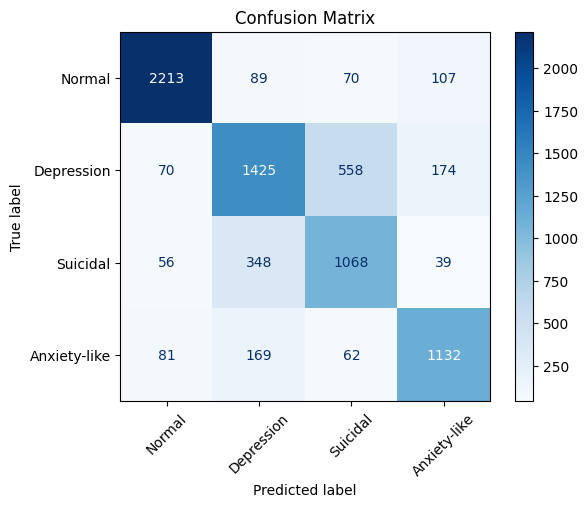

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


label_names = ['Normal', 'Depression', 'Suicidal', 'Anxiety-like']
# Set the model to evaluation mode (disables dropout, etc.)
model.eval()
y_true = []
y_pred = []
# Disable gradient calculation to speed up inference
with torch.no_grad():
    correct = 0
    total = 0
    shown_examples = 0  # limit number of example predictions to print

    for batch_idx, (inputs, labels) in enumerate(test_loader):
         # Move data to GPU/CPU device
        inputs, labels = inputs.to(device), labels.to(device)
        # Run model to get predictions
        outputs = model(inputs)
          # Get the index of the highest score as the predicted class
        _, predicted = torch.max(outputs, 1)
         # Update total and count correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
         # Save results for confusion matrix
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
         # Print up to 20 predicted vs actual labels (for inspection)
        for i in range(inputs.size(0)):
            if shown_examples >= 20:
                break
            true_label_id = labels[i].item()
            pred_label_id = predicted[i].item()
            true_label_name = label_names[true_label_id]
            pred_label_name = label_names[pred_label_id]
            print(f"True label: {true_label_name} vs Predicted: {pred_label_name}")
            shown_examples += 1
    # Calculate overall accuracy
    acc = 100.0 * correct / total
    print(f'\n Accuracy on test data: {acc}%')

     # Create and display the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot(cmap="Blues", values_format='d')
    plt.title("Confusion Matrix")
    plt.xticks(rotation=45)
    plt.show()


In [ ]:

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=label_names))

              precision    recall  f1-score   support

      Normal       0.91      0.89      0.90      2479
  Depression       0.70      0.64      0.67      2227
    Suicidal       0.61      0.71      0.65      1511
Anxiety-like       0.78      0.78      0.78      1444

    accuracy                           0.76      7661
   macro avg       0.75      0.76      0.75      7661
weighted avg       0.77      0.76      0.76      7661



# Final Note on our results

it is noticed that our accuary on our test data has changed positively when we tried out different models. For the RNN model, we could not exceed the 70 % accuracy, and that is logical given the complexity and long sequences found in our data. As for the GRU, we may notice that there is an increase in terms of accuaracy to 76 %, and for our LSTM models the accuracy ranged between 75% and 78%  for our best model. Thus we may conclude that the reason behind not achieving stronger accuracies is related to the nature of our dataset.

When we split the dataset into 4 classes, we convey 4 different categories under a class named other. This conveyment might be the reason why we did not get better results. The four mergered classes (anxiety, bipolar, stress, personality disorder) are classified as one target class that is causing label noise, after all it is a hetrogeneous class that is based on different patterns merged together. Moreover, there is a similarity between some of the depression and suicidal classes with the other class (actually with the hetrogenous classes conveying the other class), this could be solved by categorizing symptoms that similar together but may also cause class imbalance, and must be done clinicly by clincal experts. Further more, the class imbalance after the merger (although the merger some balanced the catastrophic previous class imbalance) may have something to do with our results, after all the other class has far fewer samples than normal, depression, and suicidal, thus possibly causing our models to favor the other classes.